In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import plotly.graph_objs as go
import plotly.offline as pyo
from datetime import timedelta
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Setting random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


Load and Preprocess Data
Pada bagian ini, kita akan memuat dataset yang digunakan untuk analisis, memeriksa struktur data, dan melakukan pembersihan.

In [4]:
# Loading and preprocessing data
def load_and_process_data():
    print("Memuat dan memproses data...")
    files = {
        "BBNI": "bni_5tahun_edited.csv"  # We are only using BBNI~ for the case study
    }
    df_list = []
    scalers = {}
    scalers_close = {}

    for stock, filename in files.items():
        print(f"Memuat file: {filename}")
        if not os.path.exists(filename):
            raise FileNotFoundError(f"File {filename} tidak ditemukan di {os.getcwd()}")

        df = pd.read_csv(filename)
        df.columns = df.columns.str.strip()  # Cleaning column names
        df.drop(columns=[col for col in ['Name', 'Dividends', 'Stock Splits'] if col in df.columns], inplace=True)
        df['Stock'] = stock
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.tz_localize(None)

        # Scaling the 'Close' column
        close_data = df[['Close']].astype(float)
        scaler_close = MinMaxScaler()
        scaler_close.fit(close_data)
        scalers_close[stock] = scaler_close

        # Scaling the numeric columns
        scaler = MinMaxScaler()
        df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
        scalers[stock] = scaler

        df_list.append(df)

    if not df_list:
        raise ValueError("Tidak ada data yang berhasil dimuat.")

    # Combining all stock data
    df_combined = pd.concat(df_list, axis=0).sort_values(by=["Date", "Stock"])
    df_combined.ffill(inplace=True)  # Forward fill to handle missing values
    df_combined.drop_duplicates(subset=["Date", "Stock"], keep="last", inplace=True)

    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    return df_combined, numeric_cols, scalers, df_list, scalers_close

# Load and process BBCA data
df_combined, numeric_cols, scalers, df_list, scalers_close = load_and_process_data()
df_combined.head()


Memuat dan memproses data...
Memuat file: bni_5tahun_edited.csv


,Date,Open,High,Low,Close,Volume,Stock
0,2019-12-09,0.416281,0.401771,0.422178,0.411517,0.083251,BBNI
1,2019-12-10,0.411517,0.401771,0.422178,0.413899,0.086428,BBNI
2,2019-12-11,0.418663,0.401771,0.422178,0.406754,0.071094,BBNI
3,2019-12-12,0.409135,0.404199,0.422178,0.406754,0.114550,BBNI
4,2019-12-13,0.416281,0.406627,0.426905,0.418663,0.110123,BBNI


Prepare Data for Training

In [5]:
# Prepare data for time series prediction (using a sliding window approach)
def create_time_series(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:i+time_step, :])
        y.append(data[i+time_step, 3])  # Predicting the 'Close' column
    return np.array(X), np.array(y)

# Extracting data for BBCA
stock_df = df_combined[df_combined['Stock'] == 'BBNI']
data = stock_df[numeric_cols].values

# Defining time step and future steps
time_step = 60
future_steps = 180

# Preparing training and testing data
X, y = create_time_series(data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check shapes of the data
X_train.shape, X_test.shape


((921, 60, 5), (231, 60, 5))

Build the GRU Model

In [10]:
# Build the GRU model
from tensorflow.keras import regularizers
def build_gru_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
        Dropout(0.3),
        GRU(256, kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
        Dropout(0.3),
        Dense(1)
    ])
    model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Learning rate yang lebih kecil
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
    )

    return model

# Build model
model = build_gru_model((X_train.shape[1], X_train.shape[2]))
model.summary()  # Check the model architecture


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 60, 128)        │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,545 (1.33 MB)

 Trainable params: 348,545 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model and Evaluate

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 788ms/step - loss: 2.2632 - mean_absolute_error: 0.1845 - val_loss: 1.9076 - val_mean_absolute_error: 0.0925
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 475ms/step - loss: 1.8144 - mean_absolute_error: 0.0632 - val_loss: 1.5409 - val_mean_absolute_error: 0.0234
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 339ms/step - loss: 1.4660 - mean_absolute_error: 0.0441 - val_loss: 1.2416 - val_mean_absolute_error: 0.0593
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - loss: 1.1766 - mean_absolute_error: 0.0410 - val_loss: 0.9891 - val_mean_absolute_error: 0.0181
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.9384 - mean_absolute_error: 0.0355 - val_loss: 0.7876 - val_mean_absolute_error: 0.0422
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - loss: 0.7453 - mean_absolute_error: 0.0353 - val_loss: 0.6227 - val_mean_absolute_error: 0.0290
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - loss: 0.5892 - mean_absolute_error: 0.

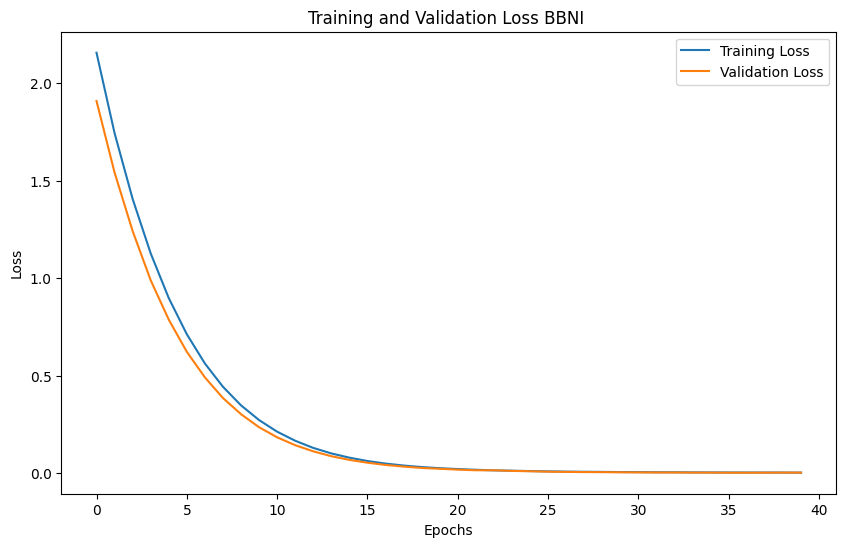

(0.003036840261625395,
 np.float64(0.05510753361950973),
 0.04173655363402937,
 0.5759365804702357)

In [11]:
# Training the model and saving the history
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, 
epochs=100, batch_size=64, 
callbacks=[early_stop], verbose=1)

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss BBNI ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
y_pred_test = model.predict(X_test, verbose=0)

# Metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

mse, rmse, mae, r2




Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 254ms/step - loss: 0.0044 - mean_absolute_error: 0.0301 - val_loss: 0.0038 - val_mean_absolute_error: 0.0315
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - loss: 0.0043 - mean_absolute_error: 0.0310 - val_loss: 0.0029 - val_mean_absolute_error: 0.0187
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 229ms/step - loss: 0.0041 - mean_absolute_error: 0.0315 - val_loss: 0.0030 - val_mean_absolute_error: 0.0217
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 324ms/step - loss: 0.0039 - mean_absolute_error: 0.0303 - val_loss: 0.0031 - val_mean_absolute_error: 0.0261
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - loss: 0.0038 - mean_absolute_error: 0.0303 - val_loss: 0.0026 - val_mean_absolute_error: 0.0188
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - loss: 0.0036 - mean_absolute_error: 0.0299 - val_loss: 0.0025 - val_mean_absolute_error: 0.0197
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0037 - mean_absolute_error: 0.0

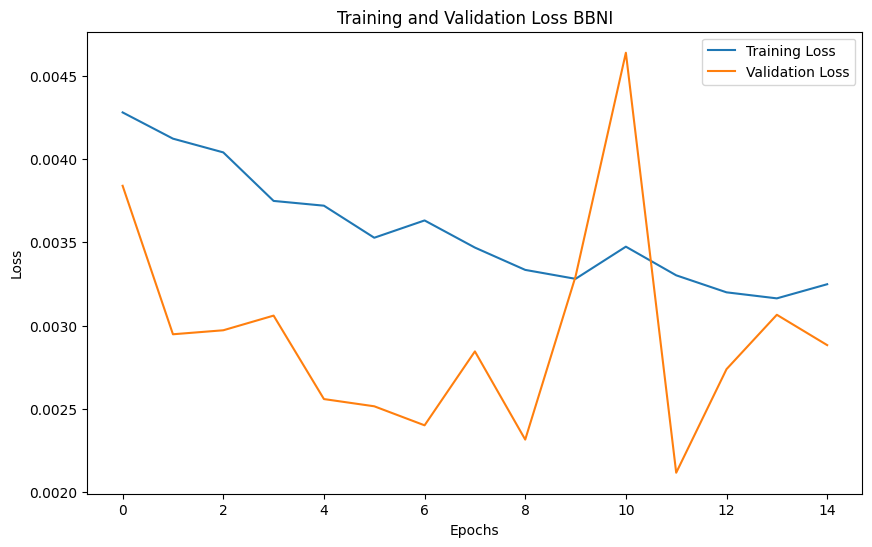

(0.0023319139523690054,
 np.float64(0.04828989493019223),
 0.03678963734224166,
 0.6743722687075102)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Training the model and saving the history
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stop], verbose=1)

# Plotting Training and Validation Loss without Best Iteration
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss BBNI')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
y_pred_test = model.predict(X_test, verbose=0)

# Metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

mse, rmse, mae, r2


Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - loss: 0.0031 - mean_absolute_error: 0.0304 - val_loss: 0.0021 - val_mean_absolute_error: 0.0209
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - loss: 0.0030 - mean_absolute_error: 0.0298 - val_loss: 0.0020 - val_mean_absolute_error: 0.0185
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 0.0031 - mean_absolute_error: 0.0302 - val_loss: 0.0021 - val_mean_absolute_error: 0.0235
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 333ms/step - loss: 0.0030 - mean_absolute_error: 0.0306 - val_loss: 0.0022 - val_mean_absolute_error: 0.0239
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - loss: 0.0031 - mean_absolute_error: 0.0315 - val_loss: 0.0031 - val_mean_absolute_error: 0.0372


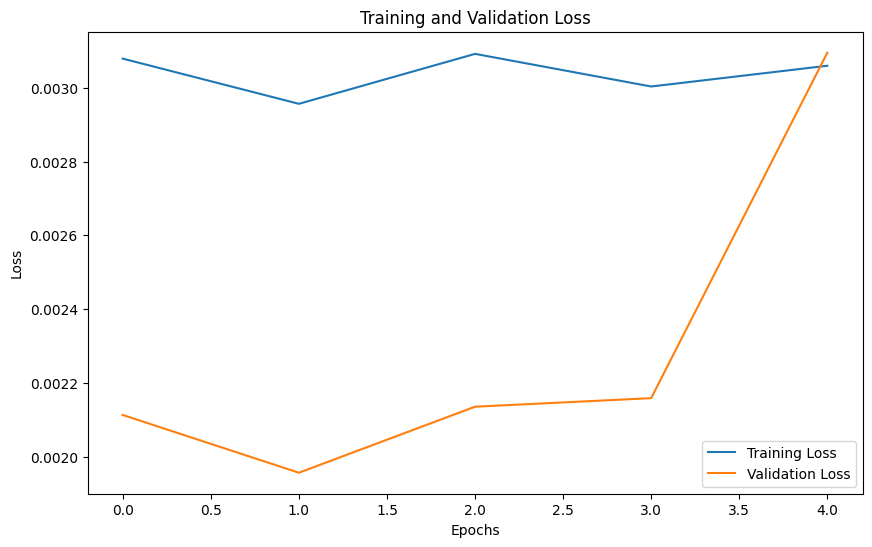

KeyError: 'mean_squared_error'

<Figure size 1000x600 with 0 Axes>

In [13]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Training the model and saving the history
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=64, callbacks=[early_stop], verbose=1)

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Training and Validation MSE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plotting Training and Validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Plotting Training and Validation R2
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_absolute_error'], label='Training R²')
plt.plot(history.history['val_mean_absolute_error'], label='Validation R²')
plt.title('Training and Validation R²')
plt.xlabel('Epochs')
plt.ylabel('R²')
plt.legend()
plt.show()

# Evaluate the model on the test set
y_pred_test = model.predict(X_test, verbose=0)

# Metrics
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

mse, rmse, mae, r2
